# Using wavelet methods to analyze GPS recordings of slow slip events

## Change-point detection using extremal phase wavelet filters

We begin by importing the Python modules that we will need during the analysis.

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from math import floor
from scipy.io import loadmat

import DWT
import MODWT
import date

%matplotlib inline

We perform the same preprocessing to the data that we have done for the DWT analysis.

In [2]:
# Choose the station
station = 'PGC5'
direction = 'lon'
dataset = 'cleaned'
filename = '../data/PANGA/' + dataset + '/' + station + '.' + direction
# Load the data
data = np.loadtxt(filename, skiprows=26)
time = data[:, 0]
disp = data[:, 1]
# Correct for the repeated value
dt = np.diff(time)
gap = np.where(dt < 1.0 / 365.0 - 0.001)[0]
time[gap[0] + 1] = time[gap[0] + 2]
time[gap[0] + 2] = 0.5 * (time[gap[0] + 2] + time[gap[0] + 3])
# Look for gaps greater than 2 days
days = 2
dt = np.diff(time)
gap = np.where(dt > days / 365.0 + 0.001)[0]
# Select a subset of the data without big gaps
ibegin = 2189
iend = 5102
time_sub = time[ibegin + 1 : iend + 1]
disp_sub = disp[ibegin + 1 : iend + 1]
# Fill the missing values by interpolation
dt = np.diff(time_sub)
gap = np.where(dt > 1.0 / 365.0 + 0.001)[0]
for i in range(0, len(gap)):
    time_sub = np.insert(time_sub, gap[i] + 1, time_sub[gap[i]] + 1.0 / 365.0)
    disp_sub = np.insert(disp_sub, gap[i] + 1, 0.5 * (disp_sub[gap[i]] + disp_sub[gap[i] + 1]))
    gap[i : ] = gap[i : ] + 1

We also need to download the tremor catalog.

In [3]:
# Load tremor data from the catalog downloaded from the PNSN
filename = '../data/timelags/08_01_2009_11_26_2014.txt'
day = np.loadtxt(filename, dtype=np.str, usecols=[0], skiprows=16)
hour = np.loadtxt(filename, dtype=np.str, usecols=[1], skiprows=16)
nt = np.shape(day)[0]
time_tremor = np.zeros(nt)
for i in range(0, nt):
    time_tremor[i] = date.string2day(day[i], hour[i])
location = np.loadtxt('../data/timelags/08_01_2009_11_26_2014.txt', usecols=[2, 3], skiprows=16)
lat_tremor = location[:, 0]
lon_tremor = location[:, 1]
k = (lat_tremor >= 47.5) & (lat_tremor <= 49.5)

We choose the maximum level for which we want to perform the MODWT analysis.

In [4]:
J = 7
time = time_sub
disp = disp_sub

We begin by the first two points of the time series, we perform the MODWT analysis, and we keep the value of the last wavelet coefficients at each level. Then, at each time setpe, we add one additional velue to the time series, and we carry out the same procedure. We then look at the evolution with time of the last wavelet coefficient.

We initialize some variables.

In [5]:
N = np.shape(disp)[0]
t0 = time[0]
dt = 1.0 / 365.0
Wlast = []
for j in range(0, J):
    Wlast.append(np.zeros(N - 1))

In [11]:
for i in range(2, N + 1):
    [W, V] = MODWT.pyramid(disp[0 : i], 'D20', J)
    for j in range(0, J):
        Wj = W[j]
        Wlast[j][i - 2] = Wj[-1]

KeyboardInterrupt: 

In [ ]:
plt.figure(1, figsize=(15, (J + 1) * 4))

# Plot data
plt.subplot2grid((J + 1, 1), (J, 0))
plt.plot(t0 + dt * np.arange(0, N), disp, 'k', label='Data')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

# Plot last wavelet coefficient at each level
for j in range(0, J):
    plt.subplot2grid((J + 1, 1), (J - j - 1, 0))
    plt.plot(t0 + dt * np.arange(1, N), Wlast[j], 'k', label = 'Level ' + str(j))
    plt.xlim(np.min(time), np.max(time))
    plt.legend(loc=1)

plt.show()

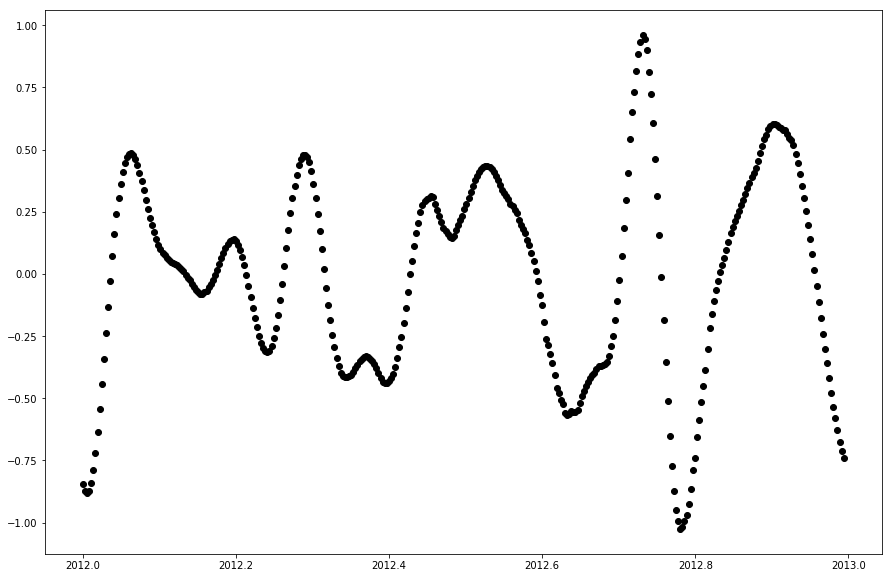

In [42]:
Nstart = 1857
Ndays = 365
dt = 1.0 / 365.0
plt.figure(1, figsize=(15, 10))
#plt.subplot(211)
for n in range(1, Ndays):
    [W, V] = MODWT.pyramid(disp[Nstart - Ndays : Nstart + n], 'D20', J)
    Wj = W[J - 1]
    plt.plot(time[Nstart + n - 1], Wj[-1], 'ko')
#plt.subplot(212)
#nt = np.shape(time_tremor)[0]
#plt.plot(np.sort(time_tremor), (1.0 / nt) * np.arange(0, len(time_tremor)))
#plt.xlim(time[Nstart - Ndays], time[Nstart + Ndays - 1])
#plt.ylim([0.4, 0.7])
plt.show()